In [200]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pystan
import seaborn as sns
import scipy as sp

# __Bayesian Inference on Spotify Streams__
#### Project work by __Ville Saarinen__ and __Sirong Huang__
## __Introduction__
The purpose of this project work is to study the features of most played (only the top 100 were selected) Spotify songs by geography and see if fitting a variety of different regression models could yield us information about the relationship of the features to the popularity of the songs. However we are aware that the true causal mechanism determining the popularity of any given song is extremely complex and that there is very probably many exogeneous factors (song's popularity is to some degree dependent on the popularity of the artist, artist's connectivity socially, cultural aspects, marketing-related, geographical etc) that are not captured by the musical features of the songs. We also need to take into consideration the fact that even the musical qualities are not completely accurately captured by the features offered by the Spotify API, but rather they are algorithmically computed approximations of the qualities they are supposed to model.   

We then proceed by showing that by conducting Bayesian inference on different geographical areas we can identify some of the culturally / geographically determined features which determine given song's popularity in that particular context.

#### __This notebook is structured in a following way:__
1. Data import and implementing common methods used throughout the model assessment and inference
2. __Introducing bayesian linear regression model__  
    2.1 Model  
    2.2 Intuitions about the Data
    2.3 Priors
3. __Modeling and inference__  
    3.1 3-covariate model with uninformative priors  
    3.2 3-covariate model with normal priors  
    3.3 5-covariate model with normal priors  
    3.4 Extended 5-covariate model with 2 interaction terms  
    3.5 Extended 5-covariate model with 4 interaction terms  
    3.6 Extended 5-covariate model with squared terms  
    3.7 Extended 5-covariate model with squared and interaction terms  
    3.8 Extended 5-covariate model with cubic and interaction terms
4. __Model comparison__
5. __Limiting the domain and inference about cultural differences__
6. __Conclusions__

## __1. Data Import and Common Methods__

#### Import stan convergence utilities from local directory 
Utilities originally by Betancourt, [see this notebook on Bayesian workflow](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

In [114]:
%run utility/stan_utility.py

#### Import data

In [115]:
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
names_2018 = ['streams', 'acousticness', 'danceability', 'loudness', 'tempo', 'valence']

global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
global_data_2018 = pd.read_csv('./data/2018_global_selected.csv',header=None, names=names)

#### Method for plotting predictive distributions

In [116]:
def plot_predictive_acc(global_data, global_data_2018, samples):
    fig, [ax1, ax2] = plt.subplots(2,1,figsize=(16,9), sharex=True)

    streams17 = exp10_t(global_data['streams'])
    
    plt.suptitle('Predictive performance')
    plt.xlabel('Song ranking by stream count')
    cols = ['blue','orange','grey']

    plt.ylim(0,max(streams17))
    plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
    X_top100 = range(1,101)
    
    mean_ypred = np.mean(samples['ypred'], axis=0)
    sd_ypred = np.sqrt(np.var(samples['ypred'], axis=0))
    
    mean_ypred_18 = np.mean(samples['ypred_2018'], axis=0)
    sd_ypred_18 = np.sqrt(np.var(samples['ypred_2018'], axis=0))
    
    ax1.plot(X_top100, streams17, '.--', color=cols[0], alpha=.5, label='Top songs for 2017')
    ax1.errorbar(X_top100, mean_ypred, yerr=sd_ypred, fmt='o-', color='orange', label='Prediction')
    
    sns.regplot(list(X_top100), list(np.mean(samples['ypred'], axis=0)), 'o-', color=cols[2], ax=ax1, scatter=False, 
                label='Prediction regression fit with 95%-ci')

    ax1.legend(loc='best')
    ax1.set_ylabel('Streams')

    ax2.plot(X_top100, global_data_2018['streams'], '.-', color=cols[0], alpha=.5, label='Top songs for 2018')
    ax2.errorbar(X_top100, mean_ypred_18, yerr=sd_ypred_18, fmt='o-', color='orange', label='Prediction')
    
    sns.regplot(list(X_top100), list(mean_ypred_18), 'o-', color=cols[2], ax=ax2, scatter=False, 
                label='Prediction regression fit with 95%-ci')
    ax2.legend(loc='best')
    ax2.set_ylabel('Streams')

    plt.tight_layout()

#### Setting up Dataframe to Accommodate Model Comparison

In [117]:
loos = pd.DataFrame(index=[], columns=["loo", "warning", "treedepth", "div"])
samples_list = []

nums_b = iter([3,3,5,7,9,12,14,19]) # number of beta-priors indexed by model

## __2. Introducing Bayesian Linear Regression Model__

### __2.1 Model__
#### __Motivation__ 
We are interested in finding out which features in the spotify's song data determine the number of streams in Spotify. We will study this hypothesis by using multiple linear models which model the linear relationship between the variable that includes data about the number of streams with other variables which we use as predictors. Models are trained using the global aggregated data queried from Spotify API for year 2017. We will do prediction for both 2017 as a model checking procedure and for 2018 data for curiosity. The `streams` in the 2018 data set already includes data for 11 months of year 2018. 

#### __Assumptions__
We first assume that the relationship between $d$-dimension predictor variables $X = \{X_1,X_2,...,X_d\}$ each having $n$ elements, and observations $Y = \{y_1,y_2,...,y_n\}$ (streams) is modeled by *linear dependence*. We also assume that all elements $y \in Y$ and $x \in X$ are independent of each other. 

The mean $\mu$ of model is described by: $\mu = \mathbb{E}[y_i \mid \beta, X] = \alpha + \beta_1 X_1 + \beta_2 X_2 + , ... , + \beta_d X_d\;$, where $\alpha$ is the intercept and $\beta = \{\beta_1, \beta_2, ... , \beta_d\}$ the parameter vector for coefficients.

We also need to consider the unknown error term $\sigma$. Thus in general form our model is of the form:  

$$\large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_d X_d, \;\sigma)$$

In bayesian context we are not interested about point-estimate, but rather the whole posterior distribution which takes the form:

$$\large p(\beta \mid y, X) = \frac{p(y \mid \beta,X)p(\beta\mid X)}{p(y\mid X)}$$

Exploratory data analysis showed that $Y$ is right skewed, this could suggest that our model would benefit from log-transformation. Let's take a closer look at the distribution of $Y$:

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


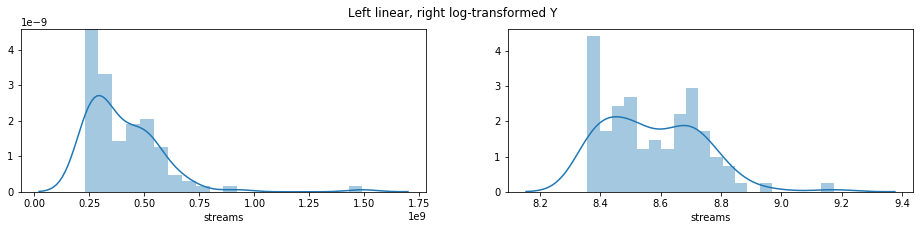

In [118]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,3))
fig.suptitle('Left linear, right log-transformed Y')
sns.distplot(global_data['streams'], ax=ax1, bins=20)
sns.distplot(np.log10(global_data['streams']), ax=ax2, bins=20)

#### Log-transformation of $Y$
Plots suggest that log-transformation evens out some of the right-skewness. Thus we will use log-transformed data for fitting the model:

In [119]:
global_data['streams'] = np.log10(global_data['streams'])

We also define functions for inverse transformation of log-data:

In [120]:
exp10 = lambda x: 10**x 
exp10_t = lambda X: np.asarray(list(map(exp10, X)))

### __2.2 Intuitions About the Data__
Generally we know that the true determining factors of $Y$ are extremely complex and that developing rational and workable intuitions about the $\beta$-priors is a difficult task. The task gets even more difficult as the complexity of the model increases. However we can make basic hypothesis about the way in which different predictors might affect $Y$ and do limited sensitivity analysis based on that. Based on prior knowledge we could hypothesize for example that `loudness` might be a necessary (but not sufficient) component in contemporary music for achieving popularity (there has been extensive discussion about so called 'loudness wars' in the audio engineering industry, see for example [this](https://www.soundonsound.com/sound-advice/dynamic-range-loudness-war)).

In [121]:
def plot_loudness(global_data, global_data_2018, label):
    fig = plt.figure(figsize=(18,5))
    fig.suptitle(label)
    ax1 = plt.subplot2grid((2,5), (0,0), colspan=4, rowspan=2)
    ax1.set_title('Loudness by ranking')
    
    ax1.set_ylabel('Loudness')
    ax1.set_xlabel('Song Ranking')
    ax1.plot(global_data.index.values, global_data['loudness'], '.-', label='2017 songs')
    ax1.plot(global_data_2018.index.values, global_data_2018['loudness'], '.-', label='2018 songs')
    ax1.set_ylim(-4,4)
    ax1.legend()

    ax2 = plt.subplot2grid((2,5), (0,4), colspan=1, rowspan=1)
    ax2.set_title('Loudness kde')

    sns.distplot(global_data['loudness'], hist=True, kde=True, ax=ax2)
    ax2.set_xlabel('loudness')
    
    ax3 = plt.subplot2grid((2,5), (1,4), colspan=1, rowspan=1)    
    sns.distplot(global_data_2018['loudness'], color='orange', hist=True, kde=True, ax=ax3)
    ax3.set_xlabel('loudness')

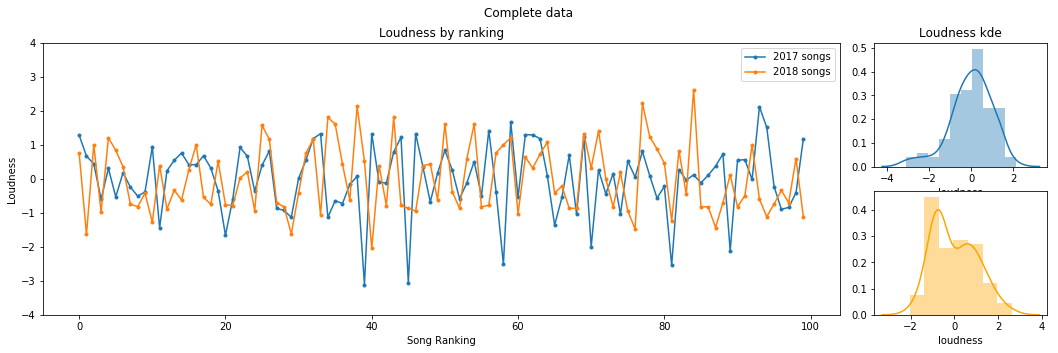

In [122]:
plot_loudness(global_data, global_data_2018, 'Complete data')

We can see quite even and symmetric distributions centered around 0 which doesn't seem to support the `loudness` hypothesis. We can further eplain this by noticing that there are slower songs and ballads also in the mix. Thus by further hypothesizing that songs with high `acousticness` and low `danceability` scores are less loud than for example electronic music that is usually highly compressed and thus easier to make loud. If we remove songs that are highly acoustic and non-danceable, we get:

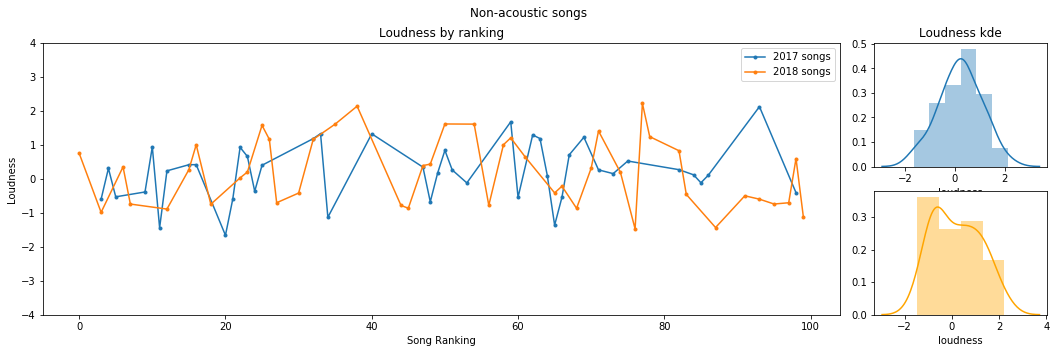

In [123]:
glob_non_ac = global_data[global_data['acousticness'] < -.5]
glob_non_ac_2018 = global_data_2018[global_data_2018['acousticness'] < -.5]
plot_loudness(glob_non_ac, glob_non_ac_2018, 'Non-acoustic songs')

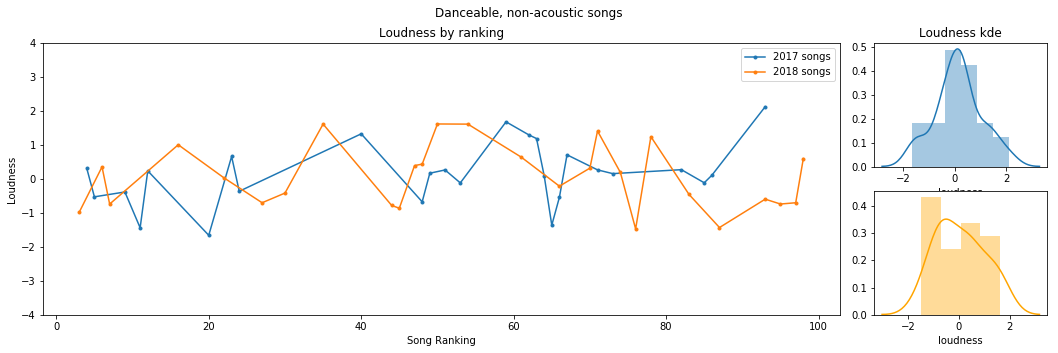

In [124]:
glob_non_ac = glob_non_ac[glob_non_ac['danceability'] > 0]
glob_non_ac_2018 = glob_non_ac_2018[glob_non_ac_2018['danceability'] > 0]
plot_loudness(glob_non_ac, glob_non_ac_2018, 'Danceable, non-acoustic songs')

Observations that are left after the filtering are quite homogenously distributed along the ordered top 100 observations. Kernel density estimates show that the expected value for the distribution has not significantly increased. This lets us conclude that our simple hypothesis about which features determine `loudness` didn't survive through simple exploration of the data. This suggests that it is difficult to understand the true complexity of the data, let alone make intuitive explanations about underlying true data generating process.

## __2. Priors__
In light of our a priori understanding about the data, what can we then say about distribution of priors? In our model $\alpha$ determines the intercept point $x_0$ where $y=0$. However already this is difficult to have clear intuitions about in higher dimensions. We also have $\beta$-coefficients which together determine the slope of the line. As we saw in the previous sub-section, it is not trivial to develop well working intuitions about the way in which predictors affect the $Y$. As our domain knowledge is very restricted (compared to for example data analyst who have been working with this type of audio streaming data sets for years), we feel that in this particular case it is better to let the observed data drive the conclusions. Thus we will only use uninformative or weakly informative priors when defining the models.

## __3. Modeling and Inference__

In this notebook each model will go through following stages:     
  * Justifying prior selection
  * Convergence diagnostics
  * Predictive distribution checking
  * Model evaluation

## __3.1 Uninformative model__ | Three predictors with uninformative priors
For the first model we select only three of the predictor variables based on 1) feature importance based on random forest (pre-processing-notebook) 2) collinearity (EDA-notebook) -- because of the assumptions of the linear model, we want to avoid highly collinear pairs such as `loudness ~ energy` and `valence` which is potentially collinear with many other covariates. Following predictors for this models are `danceability, acousticness` and `tempo`. 

Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$


We start the modeling with uninformative priors. This type of simple model gives us a crude picture of what the bayesian inference can tell us about the data, and it gives us a reference model which we can then compare the more complex models on.  
Here we let Stan take care of the priors, and it chooses __*uniform priors by default*__. This is also known as the *ordinary linear regression*:

### __Load model__

In [125]:
model_name = ['Model 1: 3 Predictors, Uninformative']
filename = 'lin_3_uninformative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // tempo
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred; 
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred_2018;
    vector[N] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred_2018[j] = normal_rng(a + b[1]*X1pred[j] + b[2]*X2pred[j] + b[3]*X3pred[j], sigma);
        ypred[j] = normal_rng(a + b[1]*X1[j] + b[2]*X2[j] + b[

In [126]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [127]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

Using cached StanModel


In [128]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [129]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.574020  0.000230  0.016568  8.541730  8.562789  8.574002  8.585367   
b[1]   0.005546  0.000241  0.017146 -0.028468 -0.005915  0.005712  0.017246   
b[2]  -0.010717  0.000256  0.016783 -0.043686 -0.021864 -0.011019  0.000424   
b[3]   0.008339  0.000236  0.016575 -0.024184 -0.002362  0.008310  0.019349   
sigma  0.164847  0.000173  0.011938  0.143441  0.156598  0.164281  0.172501   

          97.5%        n_eff      Rhat  
a      8.606088  5210.029959  0.999621  
b[1]   0.038926  5069.530285  0.999476  
b[2]   0.022094  4313.639694  1.000018  
b[3]   0.041235  4949.110421  1.000324  
sigma  0.189788  4769.479483  1.000074

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [130]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [131]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [132]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 1.0318067572383325) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.1361647521677989) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.103543930553839) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.0208567253797642) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

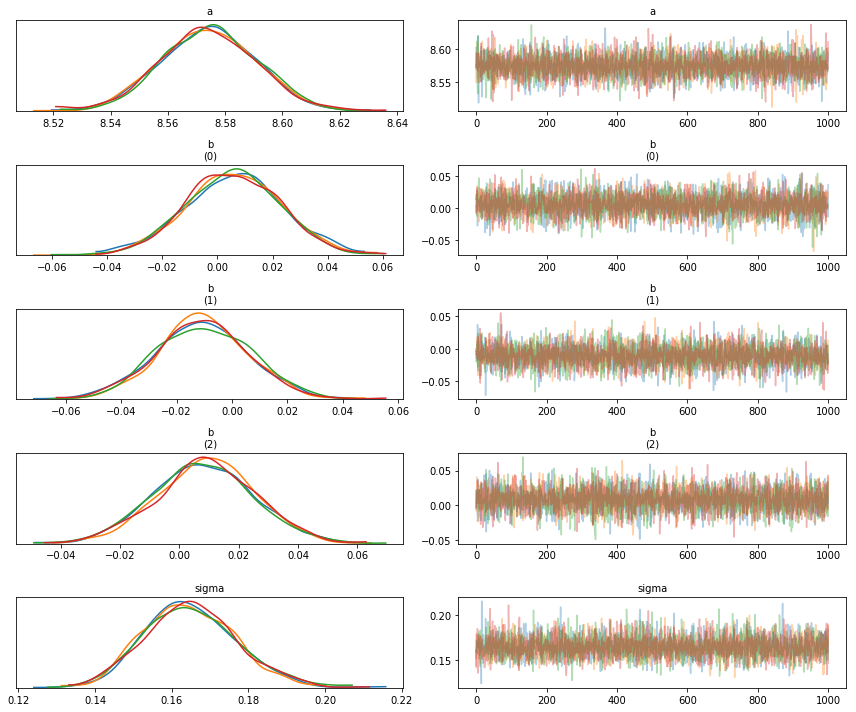

In [133]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [134]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


Model   div energy         loo       loo_se  \
0  Model 1: 3 Predictors, Uninformative  True   True  113.134365  2313.256802   

         p_loo treedepth warning  
0  6710.799655      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [135]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


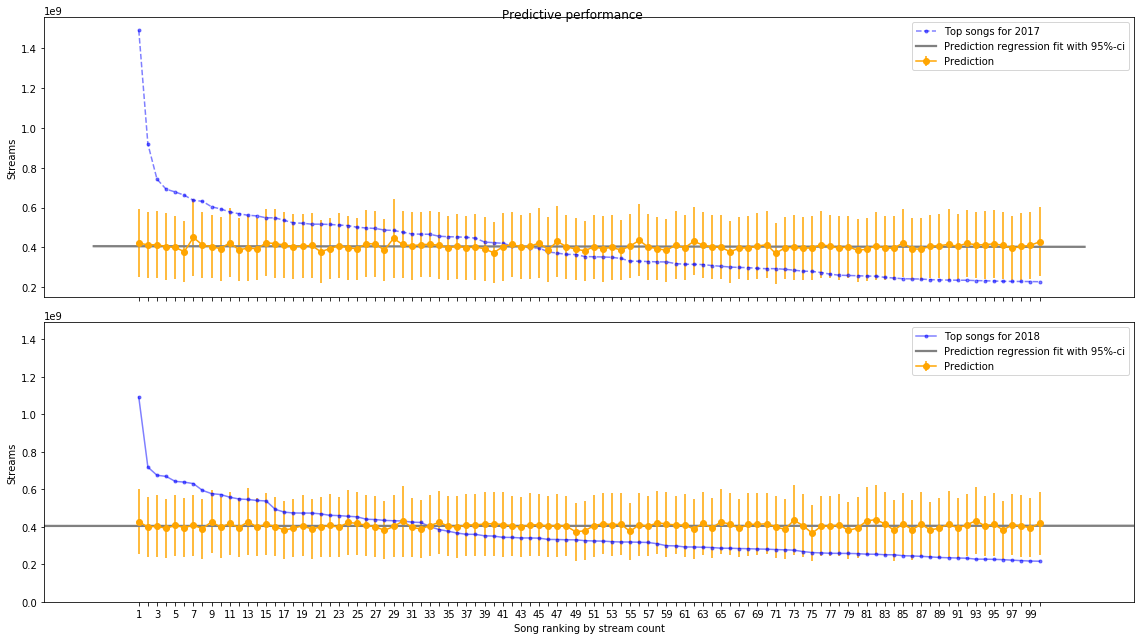

In [136]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __3.2 Weakly Informative model 1__ | Three predictors with normal priors
One of the common priors for linear regression is Zellner's g-prior with independent Gaussian priors such that for each $j \mid 1 \leq j \leq d$ and $\beta_j \sim N(0, \frac{\sigma^2}{g})$ and often the unit information prior $g = 1 / n$ is used.

For the second model we add normal priors, thus making the model normal linear model.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$

Now we also assume independent prior distributions following Zellner's g-prior for $\alpha$ and $\beta_j$'s such that $\alpha \sim N(0, 100\sigma_0^2)$, and $\beta_j \sim N(0, 100\sigma_0^2)$, where $1 \leq j \leq 3$.

### __Load model__

In [137]:
model_name = ['Model 2: 3 Predictors, Weakly informative']
filename = 'lin_3_informative.stan'

with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // tempo
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    
    // prior means 
    real mu_a;
    vector[3] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred_2018;
    vector[N] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 201

In [138]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [139]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

Using cached StanModel


In [140]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [141]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.573217  0.000234  0.017096  8.539326  8.561836  8.573145  8.584589   
b[1]   0.005801  0.000253  0.017026 -0.026853 -0.005740  0.005666  0.017163   
b[2]  -0.010694  0.000231  0.016687 -0.042423 -0.022204 -0.010752  0.000405   
b[3]   0.008448  0.000231  0.016728 -0.024360 -0.002784  0.008303  0.019827   
sigma  0.164900  0.000183  0.012245  0.143289  0.156208  0.164334  0.172778   

          97.5%        n_eff      Rhat  
a      8.606634  5315.476778  0.999715  
b[1]   0.038753  4513.090961  1.000630  
b[2]   0.022291  5239.569796  0.999375  
b[3]   0.041492  5233.623882  0.999203  
sigma  0.190687  4483.937474  1.001197

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [142]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [143]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [144]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 1.0392071023782405) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9842360361139675) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.0867285659203396) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.1027669192997511) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

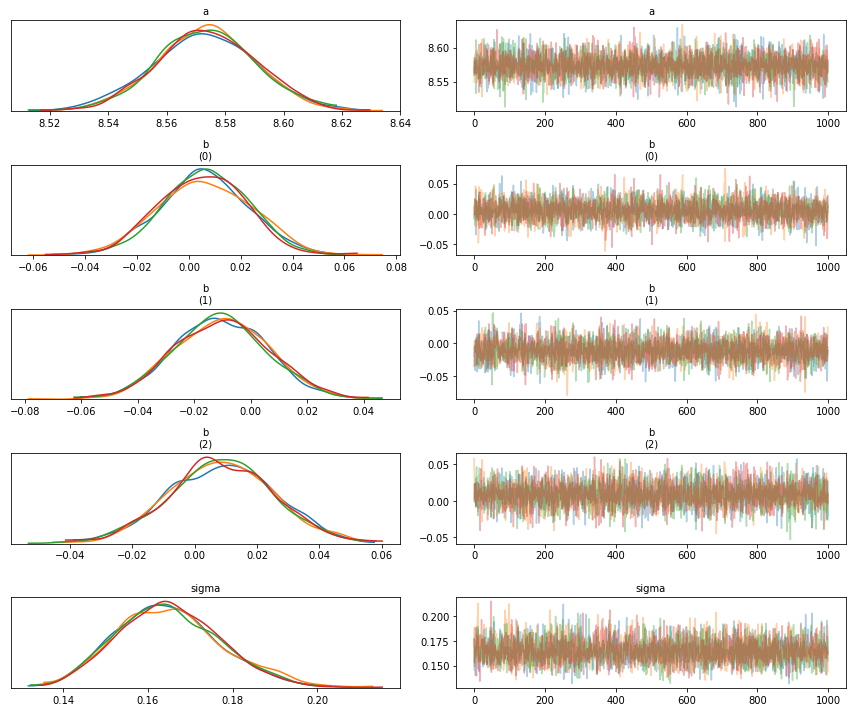

In [145]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [146]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


Model   div energy         loo  \
0       Model 1: 3 Predictors, Uninformative  True   True  113.134365   
0  Model 2: 3 Predictors, Weakly informative  True   True -182.752072   

        loo_se        p_loo treedepth warning  
0  2313.256802  6710.799655      True       1  
0  2227.493028  6360.651857      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [147]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


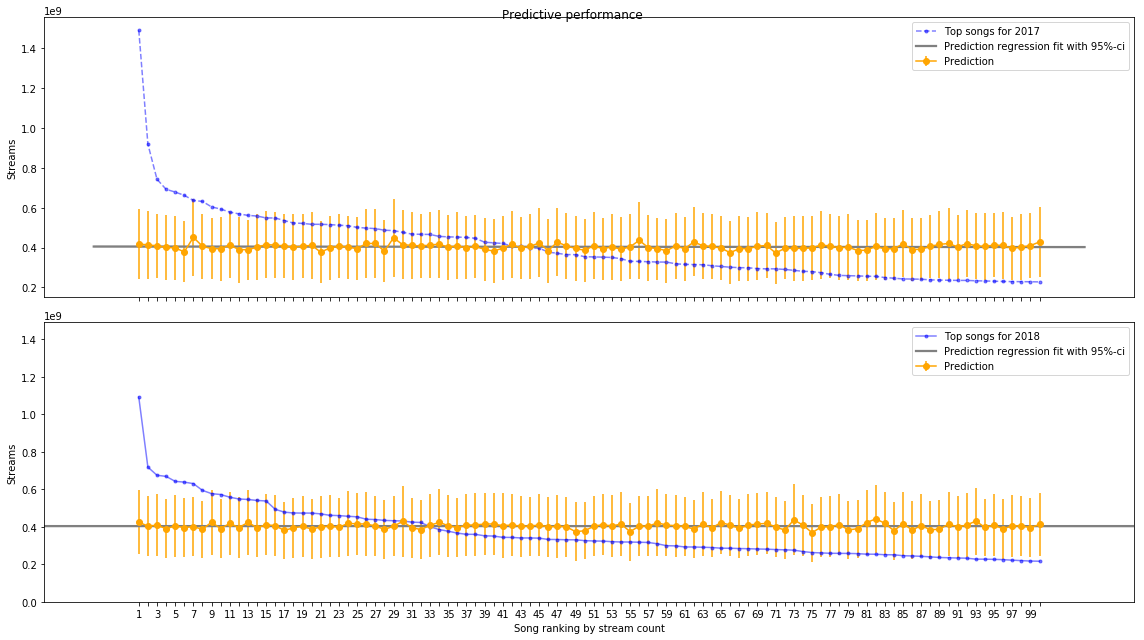

In [148]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __3.3 Weakly Informative Model 2__ | Five predictors with normal priors
In hope of better results, we will extend the model to include other covariates except energy which based on the exploratory data analysis is strongly collinear with 'loudness' and thus would not satisfy the linearity assumptions of our model. 

Third model will have 5 predictors with normal priors.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5, \;\sigma)$$

We also extend our priors accordingly.

### __Load model__

In [149]:
model_name = ['Model 3: 5 Predictors, Weakly']
filename = 'lin_5_informative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[5] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[5] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);    
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred_2018;
    vector[N] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (

In [150]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [151]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

Using cached StanModel


In [152]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [153]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.572310  0.000200  0.016550  8.540766  8.561055  8.572259  8.583484   
b[1]   0.003636  0.000259  0.017987 -0.029993 -0.009015  0.003578  0.015760   
b[2]  -0.013952  0.000330  0.020134 -0.054067 -0.027252 -0.013899 -0.000538   
b[3]   0.001833  0.000302  0.019190 -0.036005 -0.010780  0.001779  0.014303   
b[4]   0.006292  0.000275  0.018787 -0.031004 -0.006137  0.006177  0.018753   
b[5]   0.017182  0.000309  0.020223 -0.021413  0.004004  0.016893  0.030265   
sigma  0.166095  0.000171  0.012310  0.144146  0.157525  0.165370  0.173965   

          97.5%        n_eff      Rhat  
a      8.605783  6851.276951  0.999411  
b[1]   0.038245  4839.882763  0.999836  
b[2]   0.025126  3724.788994  1.000136  
b[3]   0.040675  4030.119403  0.999880  
b[4]   0.043576  4669.545436  0.999945  
b[5]   0.058237  4280.289368  0.999664  
sigma  0.192459  5157.727142  0.999577

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [154]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [155]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [156]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 1.0499308770681728) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9997914510881823) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.0614465748089699) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.1176655779461857) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

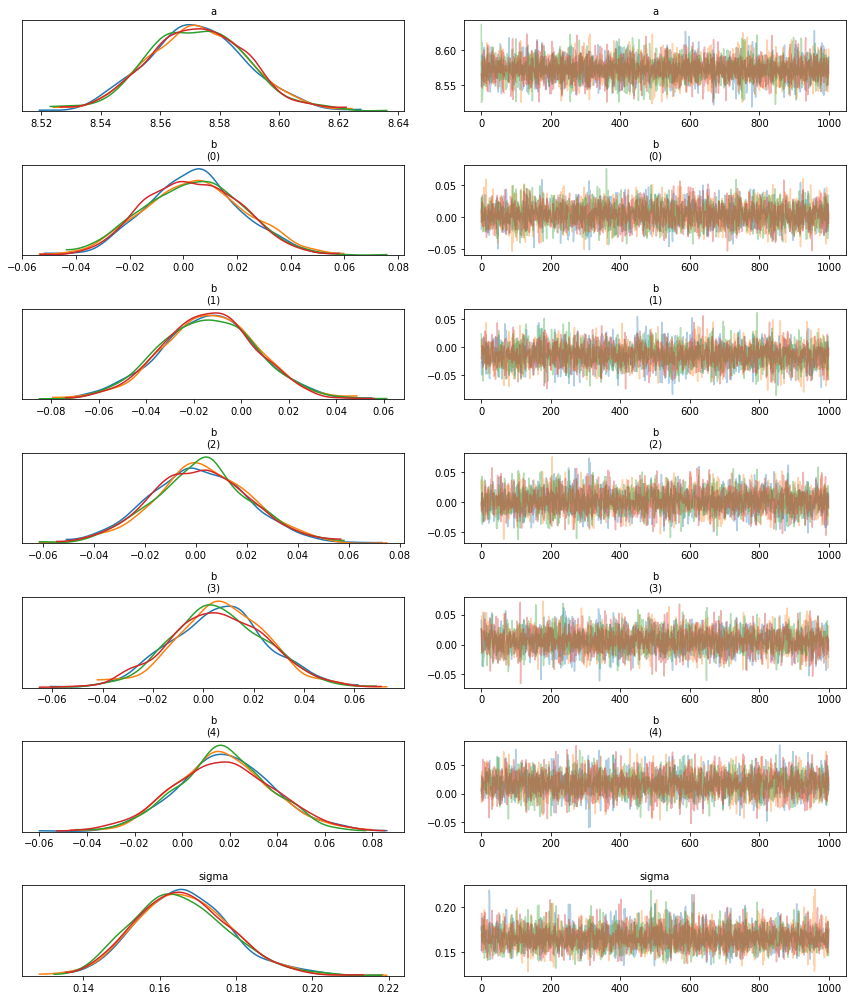

In [157]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [158]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


Model   div energy         loo  \
0       Model 1: 3 Predictors, Uninformative  True   True  113.134365   
0  Model 2: 3 Predictors, Weakly informative  True   True -182.752072   
0              Model 3: 5 Predictors, Weakly  True   True -368.520370   

        loo_se        p_loo treedepth warning  
0  2313.256802  6710.799655      True       1  
0  2227.493028  6360.651857      True       1  
0  2228.400129  6055.112946      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [159]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


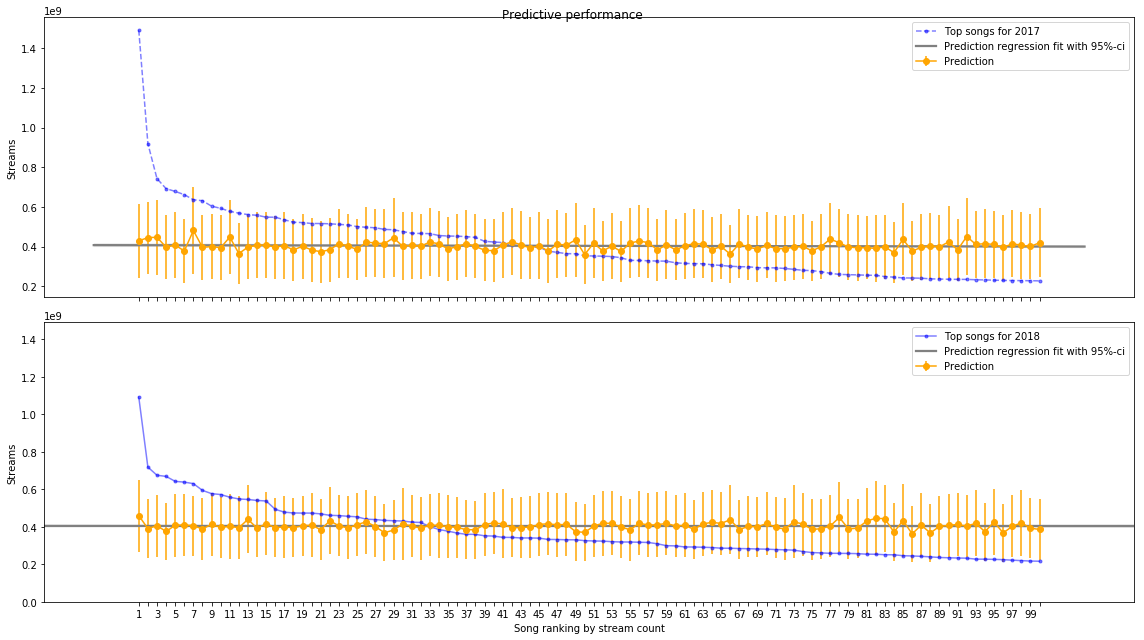

In [160]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __3.4 Extended model 1__ | Adding interaction terms
In the exploratory data analysis part of this analysis we identified multiple potential collinear relationships between covariates. We will now relax the linearity assumption of the model and introduce two new interaction terms. 

Interaction terms model:
1. potential positive collinearity between `valence` and `loudness`
2. negative collinearity between `tempo` and `danceability`.

This model will have 5 predictors with normal priors and altogether 7 parameters.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_2 X_4 + \beta_7 X_3 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [161]:
model_name = ['Model 4: 5 Predictors, Interaction terms 1']
filename = 'lin_5_informative-interaction.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[7] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[7] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5 + b[6]*X2X4 + b[7]*X3X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred_2018;
    v

In [162]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [163]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

Using cached StanModel


In [164]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [165]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.573420  0.000246  0.018249  8.536674  8.561284  8.573492  8.585691   
b[1]   0.004324  0.000275  0.017676 -0.030649 -0.007379  0.004387  0.015995   
b[2]  -0.024364  0.000351  0.021101 -0.066128 -0.038223 -0.024722 -0.010160   
b[3]   0.007065  0.000314  0.019548 -0.029794 -0.006515  0.007010  0.020107   
b[4]   0.023326  0.000307  0.019952 -0.015257  0.009965  0.023114  0.036608   
b[5]   0.019732  0.000321  0.019741 -0.019678  0.006734  0.019749  0.032594   
b[6]   0.027756  0.000229  0.015065 -0.001054  0.017616  0.027889  0.037899   
b[7]   0.025515  0.000245  0.017090 -0.008168  0.014110  0.025551  0.037478   
sigma  0.163436  0.000178  0.012052  0.142128  0.155036  0.162492  0.170818   

          97.5%        n_eff      Rhat  
a      8.609400  5497.651321  1.000241  
b[1]   0.040364  4137.768033  0.999956  
b[2]   0.017336  3607.143508  0.999930  
b[3]   0.046444  3879.724663  1.001095  
b[4]   0.062768  4226.175459  0.999742  
b[5]   0.059102  3776.857096  1.000634  
b[6]   0.056519  4345.685995  0.999739  
b[7]   0.057801  4855.116153  0.999942  
sigma  0.188832  4595.660987  0.999636

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [166]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [167]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [168]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 0.9272522932798766) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.0367266751108595) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.0358407665741491) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.970035049808842) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

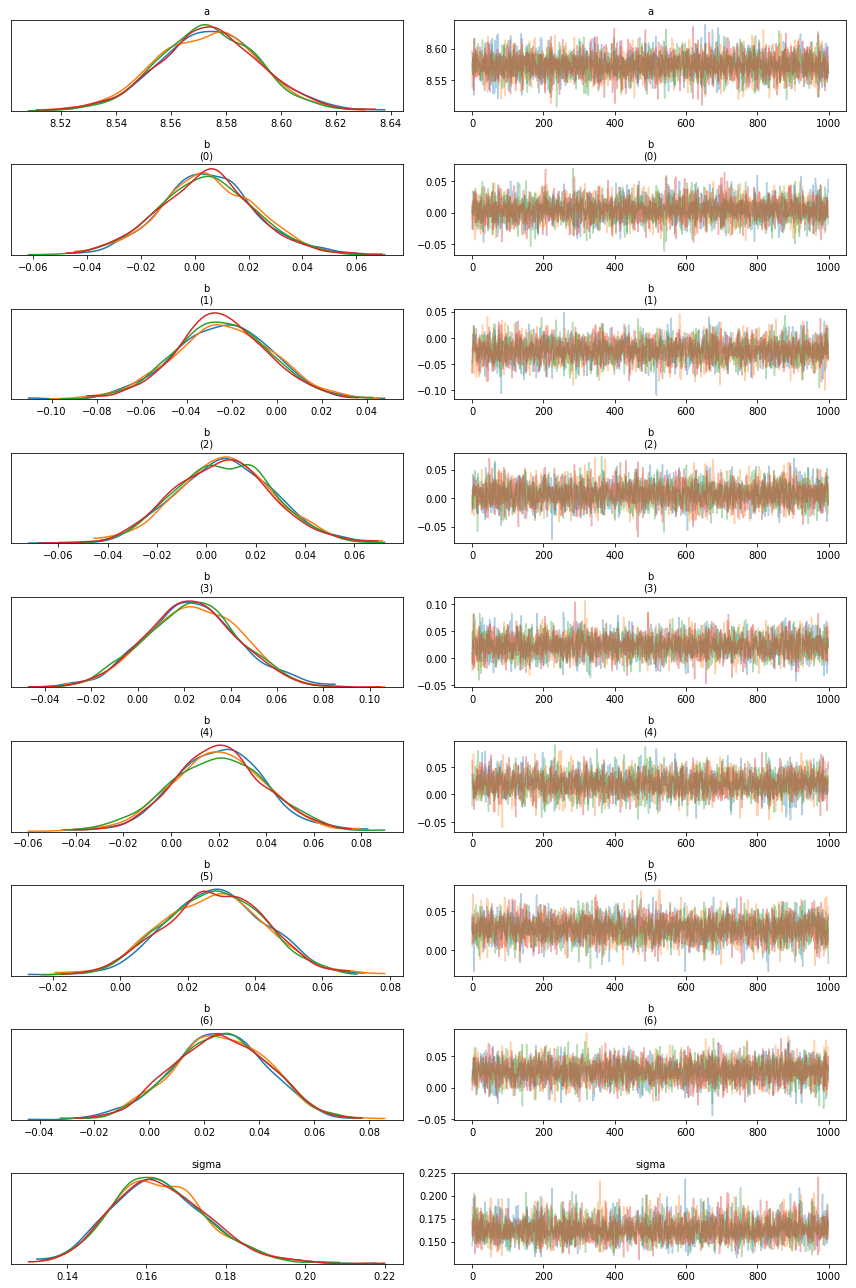

In [169]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [170]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


Model   div energy          loo  \
0        Model 1: 3 Predictors, Uninformative  True   True   113.134365   
0   Model 2: 3 Predictors, Weakly informative  True   True  -182.752072   
0               Model 3: 5 Predictors, Weakly  True   True  -368.520370   
0  Model 4: 5 Predictors, Interaction terms 1  True   True  1794.886995   

        loo_se        p_loo treedepth warning  
0  2313.256802  6710.799655      True       1  
0  2227.493028  6360.651857      True       1  
0  2228.400129  6055.112946      True       1  
0  2387.476891  7255.105740      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [171]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


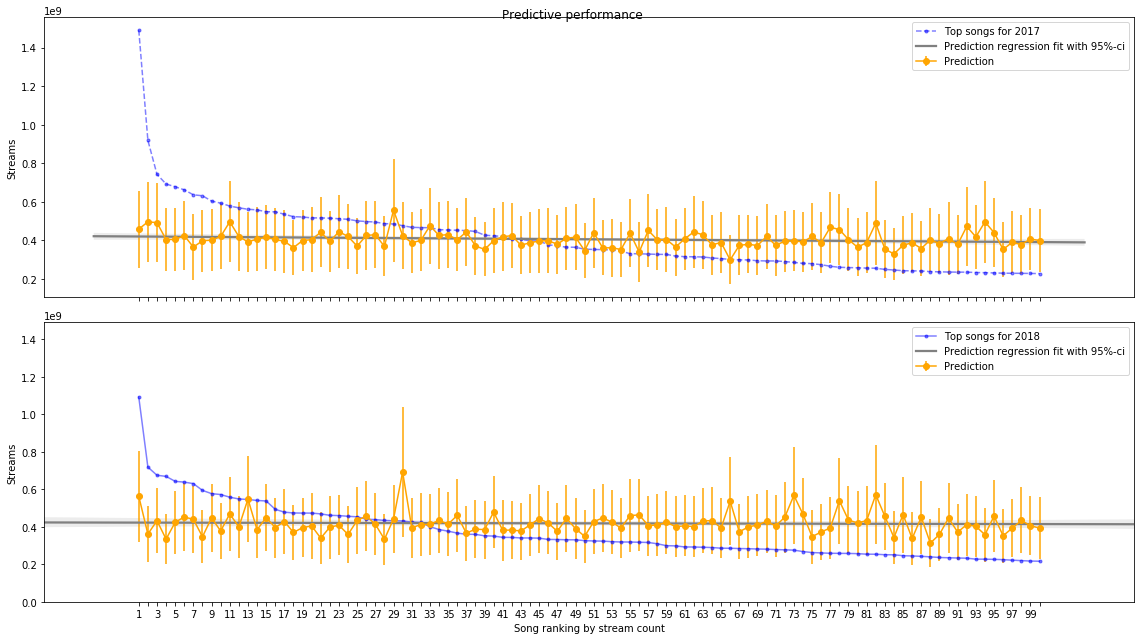

In [172]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __3.5 Extended model 2__ | Extending interaction terms 
In the exploratory data analysis part of this analysis we also plotted simple regression lines using three variables. There we noticed a possible dependence of valence with three different covariates. We already modeled the dependence with `loudness` using interaction term. Now we extend the model to include also the following interaction terms: 

1. potential positive collinearity between `valence` and `danceability`
2. potential positivie collinearity between `valence` and `acousticness`.

This model will have 5 predictors with normal priors and altogether 7 parameters.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_2 X_4 + \beta_7 X_3 X_5 + \beta_8 X_1 X_5 + \beta_9 X_2 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [173]:
model_name = ['Model 5: 5 Predictors, Interaction terms 2']
filename = 'lin_5_informative-interaction2.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[9] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[9] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X1X5;
    vector[N] X2X5;
    vector[N] X3X5;
    
    X1X5 = X1 .* X5;
    X2X5 = X2 .* X5;
    X3X5 = X3 .* X5;
    X2X4 = X2 .* X4;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5 + b[6]*X2X4 + b[7]*X3X5 + b[8]*X1X5 + b[9]*X2X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ norm

In [174]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [175]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

Using cached StanModel


In [176]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [177]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.572564  0.000255  0.017145  8.539523  8.561060  8.572373  8.584530   
b[1]  -0.004420  0.000278  0.016650 -0.036335 -0.016003 -0.004596  0.007101   
b[2]  -0.049499  0.000394  0.021080 -0.090199 -0.063698 -0.049148 -0.035640   
b[3]  -0.008548  0.000336  0.018591 -0.045443 -0.020963 -0.008526  0.003787   
b[4]   0.006688  0.000339  0.019550 -0.031710 -0.006328  0.006728  0.019646   
b[5]   0.040090  0.000339  0.019252  0.001896  0.027236  0.039988  0.053007   
b[6]   0.030583  0.000243  0.014862  0.000418  0.020458  0.030933  0.040527   
b[7]   0.036812  0.000260  0.015889  0.006412  0.025805  0.037097  0.047415   
b[8]   0.069857  0.000291  0.017929  0.034716  0.057762  0.069836  0.082292   
b[9]  -0.021709  0.000248  0.014803 -0.051114 -0.031618 -0.021814 -0.011965   
sigma  0.151467  0.000177  0.011510  0.130863  0.143412  0.150702  0.159130   

          97.5%        n_eff      Rhat  
a      8.606425  4536.143222  1.000320  
b[1]   0.029104  3596.753151  1.001299  
b[2]  -0.008734  2861.444464  1.000296  
b[3]   0.028400  3065.117293  1.000346  
b[4]   0.044858  3324.315274  1.000083  
b[5]   0.077537  3227.106392  1.000194  
b[6]   0.059496  3755.667899  0.999552  
b[7]   0.067048  3740.078223  1.000091  
b[8]   0.104573  3806.561714  1.000023  
b[9]   0.006960  3564.013389  1.001167  
sigma  0.175425  4210.238034  1.000362

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [178]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [179]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [180]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 0.9158390582261986) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9964298820192664) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.970274111300811) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.9694923826874269) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

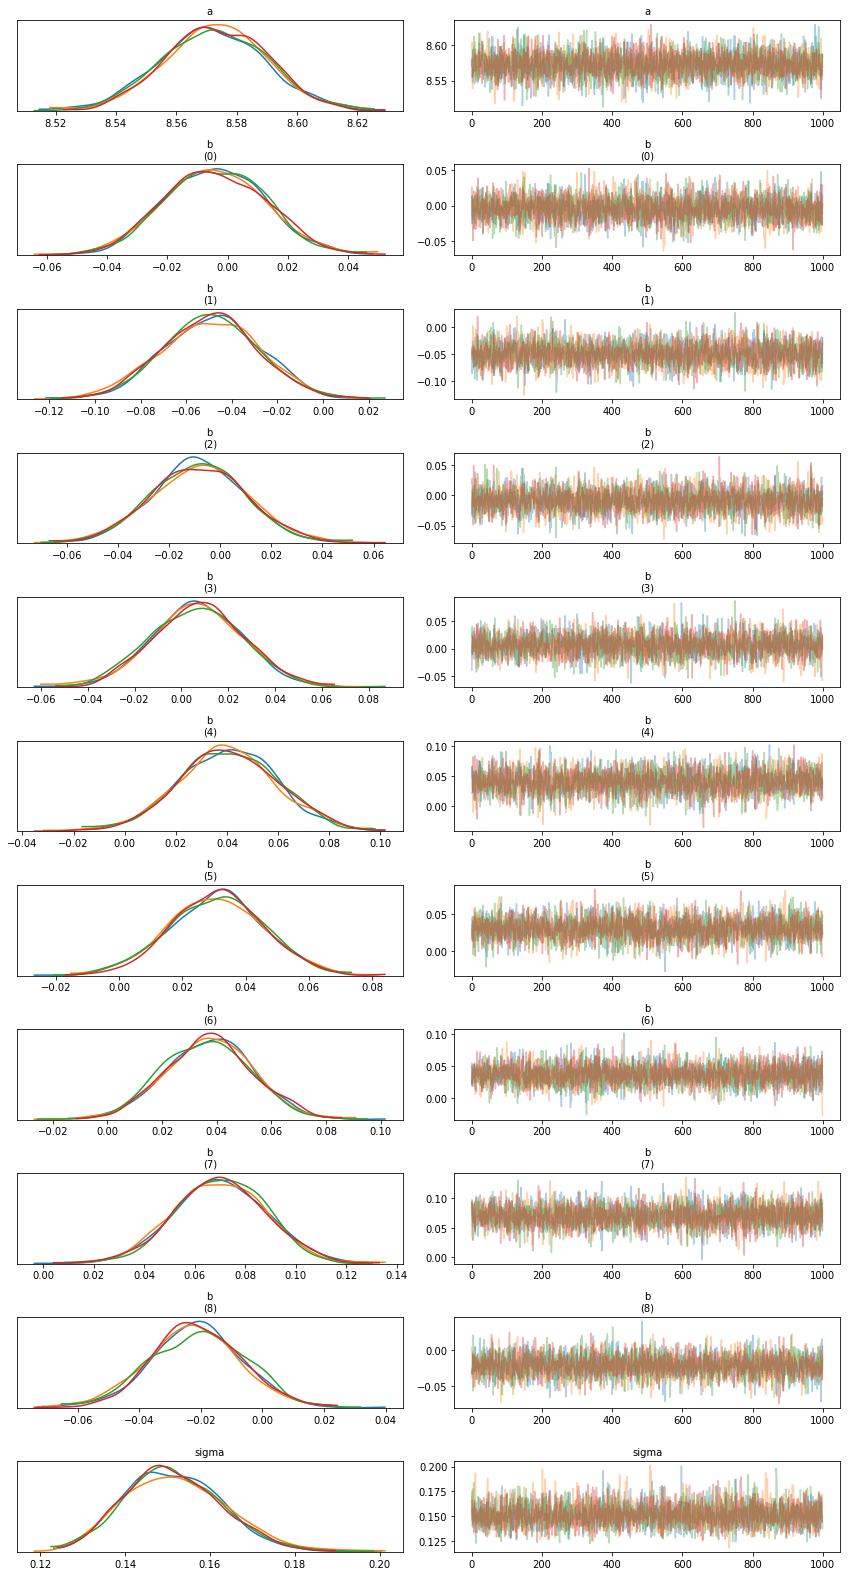

In [181]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [182]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


Model   div energy          loo  \
0        Model 1: 3 Predictors, Uninformative  True   True   113.134365   
0   Model 2: 3 Predictors, Weakly informative  True   True  -182.752072   
0               Model 3: 5 Predictors, Weakly  True   True  -368.520370   
0  Model 4: 5 Predictors, Interaction terms 1  True   True  1794.886995   
0  Model 5: 5 Predictors, Interaction terms 2  True   True  4859.278628   

        loo_se        p_loo treedepth warning  
0  2313.256802  6710.799655      True       1  
0  2227.493028  6360.651857      True       1  
0  2228.400129  6055.112946      True       1  
0  2387.476891  7255.105740      True       1  
0  2675.355310  8092.530278      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [183]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


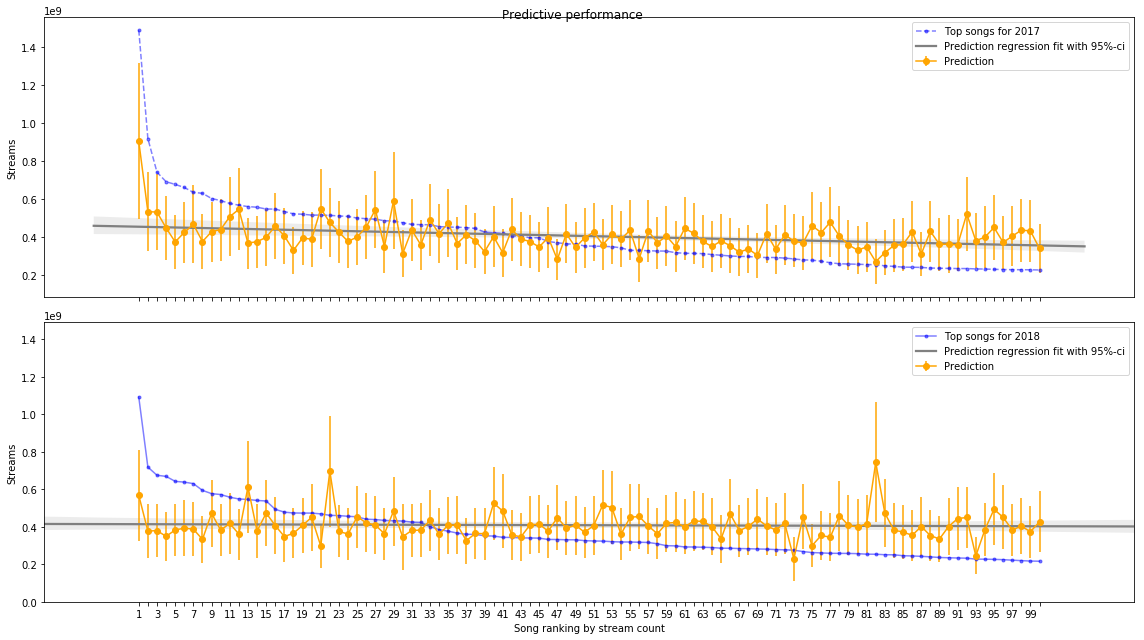

In [184]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __3.6 Extended model 3__ | Adding second order polynomials
We will now relax the linearity assumptions even further by adding higher order polynomial terms.

We will first only include 2 interaction terms in order to compare the performance with next model using all 4 of the interaction terms. Thus the model will have 5 predictors with normal priors, two interaction terms and newly introduced 5 second order terms.
Complete model takes the form:

$$ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_1^2 + \beta_7 X_2^2 + \beta_8 X_3^2 + \beta_9 X_4^2 + \beta_{10} X_5^2 + \beta_{11} X_2 X_4 + \beta_{12} X_3 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [185]:
model_name = ['Model 6: 5 Predictors, Squared terms']
filename = 'lin_5_informative-second_order.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[12] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[12] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    vector[N] X11;
    vector[N] X22;
    vector[N] X33;
    vector[N] X44;
    vector[N] X55;
    
    X11 = X1 .* X1;
    X22 = X2 .* X2;
    X33 = X3 .* X3;
    X44 = X4 .* X4;
    X55 = X5 .* X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + 

In [186]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [187]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

Using cached StanModel


In [188]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [189]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.555323  0.000714  0.035266  8.486925  8.531305  8.555531  8.579022   
b[1]  -0.021088  0.000440  0.024608 -0.070041 -0.037517 -0.020823 -0.004819   
b[2]  -0.017498  0.000363  0.022217 -0.060621 -0.032906 -0.017957 -0.002756   
b[3]  -0.003148  0.000368  0.021589 -0.046103 -0.017722 -0.003164  0.011703   
b[4]   0.031936  0.000369  0.023845 -0.014970  0.016340  0.032286  0.048060   
b[5]   0.021775  0.000322  0.020548 -0.018809  0.007748  0.021978  0.035657   
b[6]   0.028904  0.000299  0.016200 -0.002422  0.018097  0.028891  0.039471   
b[7]  -0.007219  0.000237  0.013343 -0.033763 -0.015761 -0.006983  0.001456   
b[8]  -0.014197  0.000218  0.012885 -0.039894 -0.022988 -0.014182 -0.005383   
b[9]  -0.006547  0.000339  0.018151 -0.041179 -0.018771 -0.006613  0.005193   
b[10]  0.013815  0.000321  0.018428 -0.022980  0.001641  0.013892  0.026031   
b[11]  0.017619  0.000341  0.020318 -0.022042  0.004227  0.017317  0.031078   
b[12]  0.024061  0.000416  0.023504 -0.021903  0.008478  0.023615  0.039433   
sigma  0.162669  0.000196  0.012772  0.140301  0.153691  0.161903  0.170616   

          97.5%        n_eff      Rhat  
a      8.624061  2436.715524  1.000203  
b[1]   0.026925  3132.896235  0.999545  
b[2]   0.027782  3746.574169  1.000036  
b[3]   0.038914  3433.645025  1.000222  
b[4]   0.078145  4179.951906  0.999547  
b[5]   0.062123  4062.981654  0.999338  
b[6]   0.060997  2938.362753  0.999629  
b[7]   0.019681  3180.783640  1.000633  
b[8]   0.010772  3501.409272  1.000167  
b[9]   0.029707  2865.840714  0.999869  
b[10]  0.049979  3297.103647  0.999960  
b[11]  0.056928  3548.707942  1.000428  
b[12]  0.071700  3192.279908  0.999815  
sigma  0.190762  4266.528013  0.999779

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [190]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [191]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [192]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 0.9536842710373213) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9886545492095813) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.9691530240408427) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.0012391737145216) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

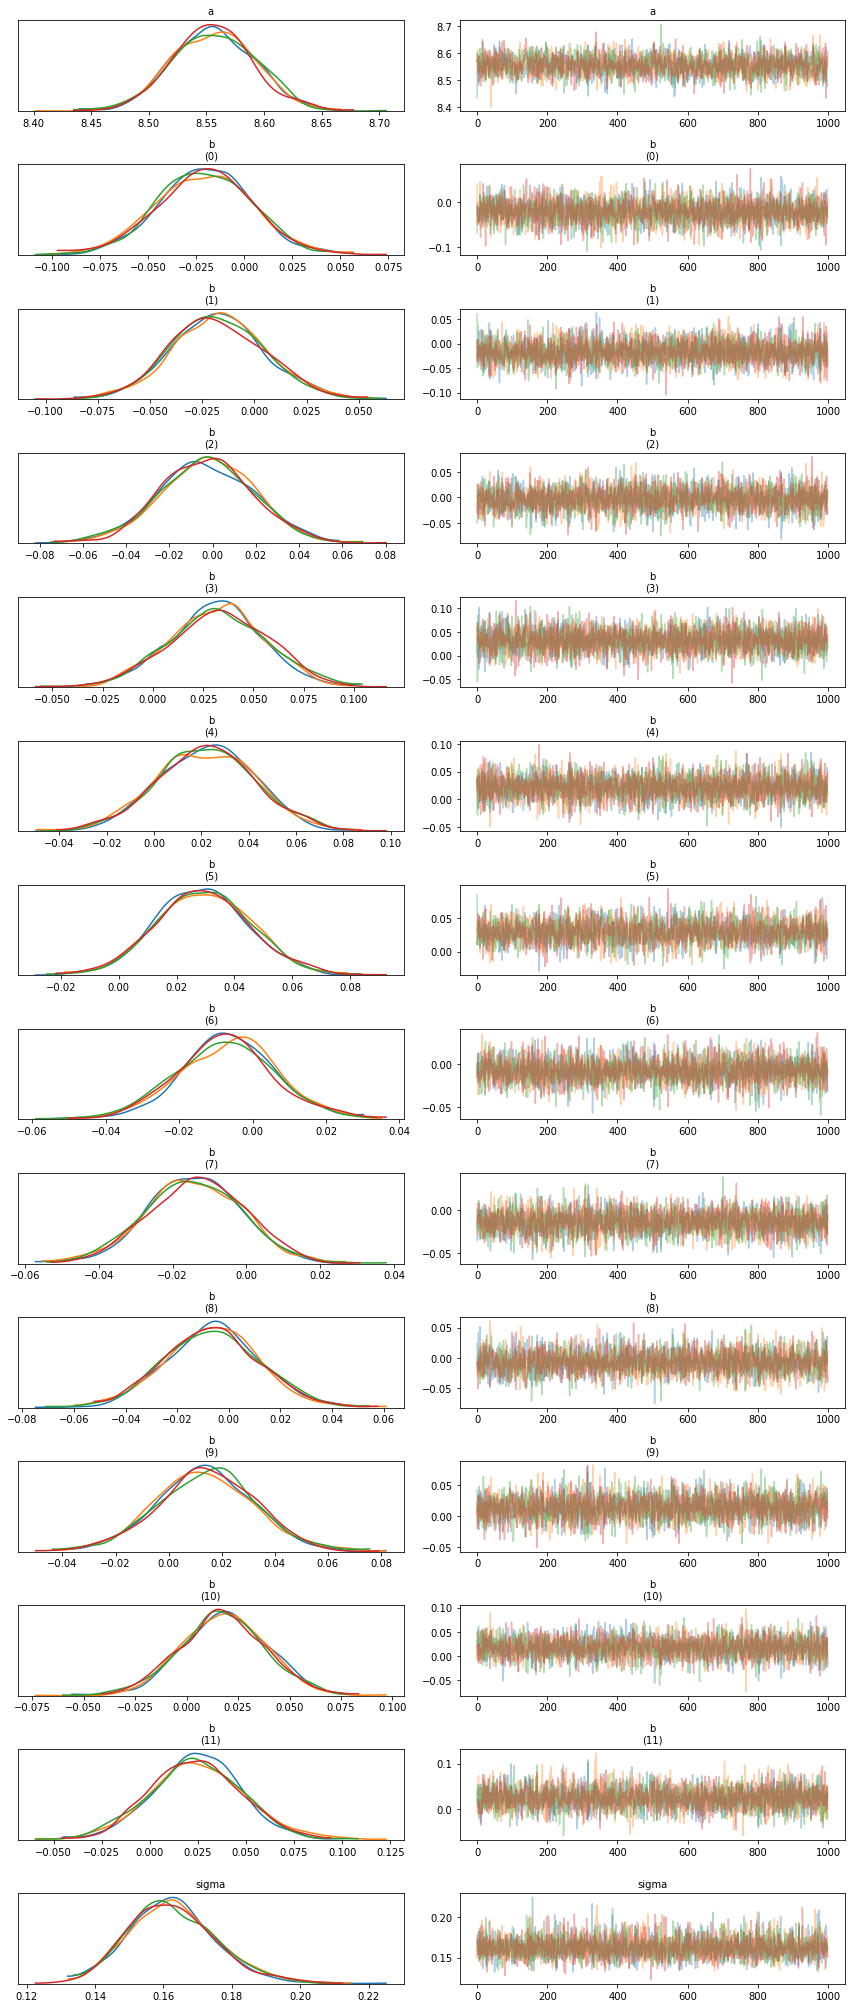

In [193]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [194]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


Model   div energy          loo  \
0        Model 1: 3 Predictors, Uninformative  True   True   113.134365   
0   Model 2: 3 Predictors, Weakly informative  True   True  -182.752072   
0               Model 3: 5 Predictors, Weakly  True   True  -368.520370   
0  Model 4: 5 Predictors, Interaction terms 1  True   True  1794.886995   
0  Model 5: 5 Predictors, Interaction terms 2  True   True  4859.278628   
0        Model 6: 5 Predictors, Squared terms  True   True  3047.778717   

        loo_se        p_loo treedepth warning  
0  2313.256802  6710.799655      True       1  
0  2227.493028  6360.651857      True       1  
0  2228.400129  6055.112946      True       1  
0  2387.476891  7255.105740      True       1  
0  2675.355310  8092.530278      True       1  
0  2434.348557  7351.170899      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [195]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


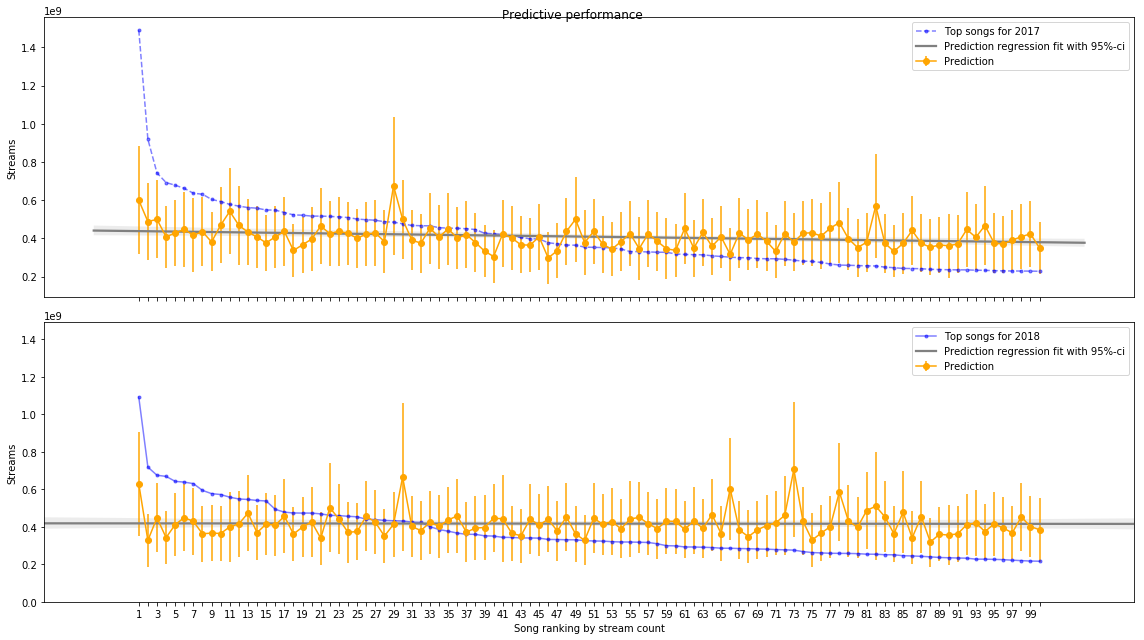

In [196]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __3.7 Extended model 4__ | Adding second order polynomials (with all interaction terms)

Then the model with squared terms and 4 interactions.

$$ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_1^2 + \beta_7 X_2^2 + \beta_8 X_3^2 + \beta_9 X_4^2 + \beta_{10} X_5^2 + \beta_{11} X_2 X_4 + \beta_{12} X_3 X_5 +\beta_{13} X_1 X_5 + \beta_{14} X_2 X_5, \;\sigma)$$

We also extend our (normal) priors accordingly.

### __Load model__

In [85]:
model_name = ['Model 7: 5 Predictors, squared terms + interaction']
filename = 'lin_5_informative-second_order-inter.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[14] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[14] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X1X5;
    vector[N] X2X5;
    vector[N] X3X5;
    vector[N] X11;
    vector[N] X22;
    vector[N] X33;
    vector[N] X44;
    vector[N] X55;
    
    X1X5 = X1 .* X5;
    X2X5 = X2 .* X5;
    X3X5 = X3 .* X5;
    X2X4 = X2 .* X4;
    
    X11 = X1 .* X1;
    X22 = X2 .* X2;
    X33 = X3 .* X3;
    X4

In [86]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [87]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39f0e9cf337c63ff5ddeaedf8c44671a NOW.
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpcpvn3a6c/stanfit4anon_model_39f0e9cf337c63ff5ddeaedf8c44671a_8717975436288309401.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [88]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [89]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.564150  0.000701  0.033060  8.501262  8.541884  8.563512  8.587416   
b[1]  -0.025143  0.000448  0.024071 -0.071489 -0.041309 -0.025266 -0.009367   
b[2]  -0.046926  0.000407  0.022373 -0.090434 -0.062057 -0.047026 -0.031933   
b[3]  -0.015141  0.000347  0.020198 -0.053642 -0.029176 -0.015480 -0.001336   
b[4]   0.023408  0.000329  0.020837 -0.017434  0.009558  0.023376  0.037337   
b[5]   0.046173  0.000349  0.019577  0.008289  0.032898  0.046161  0.059297   
b[6]   0.025509  0.000317  0.015830 -0.005998  0.014986  0.025395  0.036237   
b[7]  -0.003833  0.000222  0.013251 -0.030666 -0.012488 -0.003867  0.005142   
b[8]  -0.005172  0.000215  0.012303 -0.029192 -0.013428 -0.005359  0.003214   
b[9]  -0.022630  0.000369  0.017995 -0.057734 -0.034948 -0.022761 -0.010998   
b[10]  0.011854  0.000331  0.019395 -0.026309 -0.001230  0.012247  0.025006   
b[11]  0.013029  0.000334  0.019357 -0.024504 -0.000001  0.013023  0.025813   
b[12]  0.030294  0.000398  0.021909 -0.013035  0.015998  0.030250  0.044723   
b[13]  0.068295  0.000287  0.018948  0.030834  0.055924  0.068535  0.081018   
b[14] -0.027093  0.000296  0.018821 -0.064996 -0.039927 -0.026807 -0.014286   
sigma  0.151191  0.000178  0.011722  0.129813  0.142930  0.150582  0.158655   

          97.5%        n_eff      Rhat  
a      8.628356  2225.436499  1.000913  
b[1]   0.022230  2885.939187  0.999657  
b[2]  -0.003102  3028.903023  1.000410  
b[3]   0.024193  3387.373090  1.000672  
b[4]   0.064581  4000.323445  1.001218  
b[5]   0.084611  3141.591995  1.000419  
b[6]   0.056733  2487.840613  1.000056  
b[7]   0.022345  3578.026890  1.000341  
b[8]   0.019097  3263.890623  1.000605  
b[9]   0.013748  2373.542588  1.001730  
b[10]  0.050826  3434.012795  1.000326  
b[11]  0.051276  3363.286583  1.000609  
b[12]  0.074402  3024.668212  0.999692  
b[13]  0.105121  4359.413896  1.000384  
b[14]  0.009257  4049.435916  1.000765  
sigma  0.176058  4336.873828  0.999639

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [90]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [91]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [92]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 1.0425190318580502) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9184324437145096) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.9254099938844653) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.9337181108908835) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

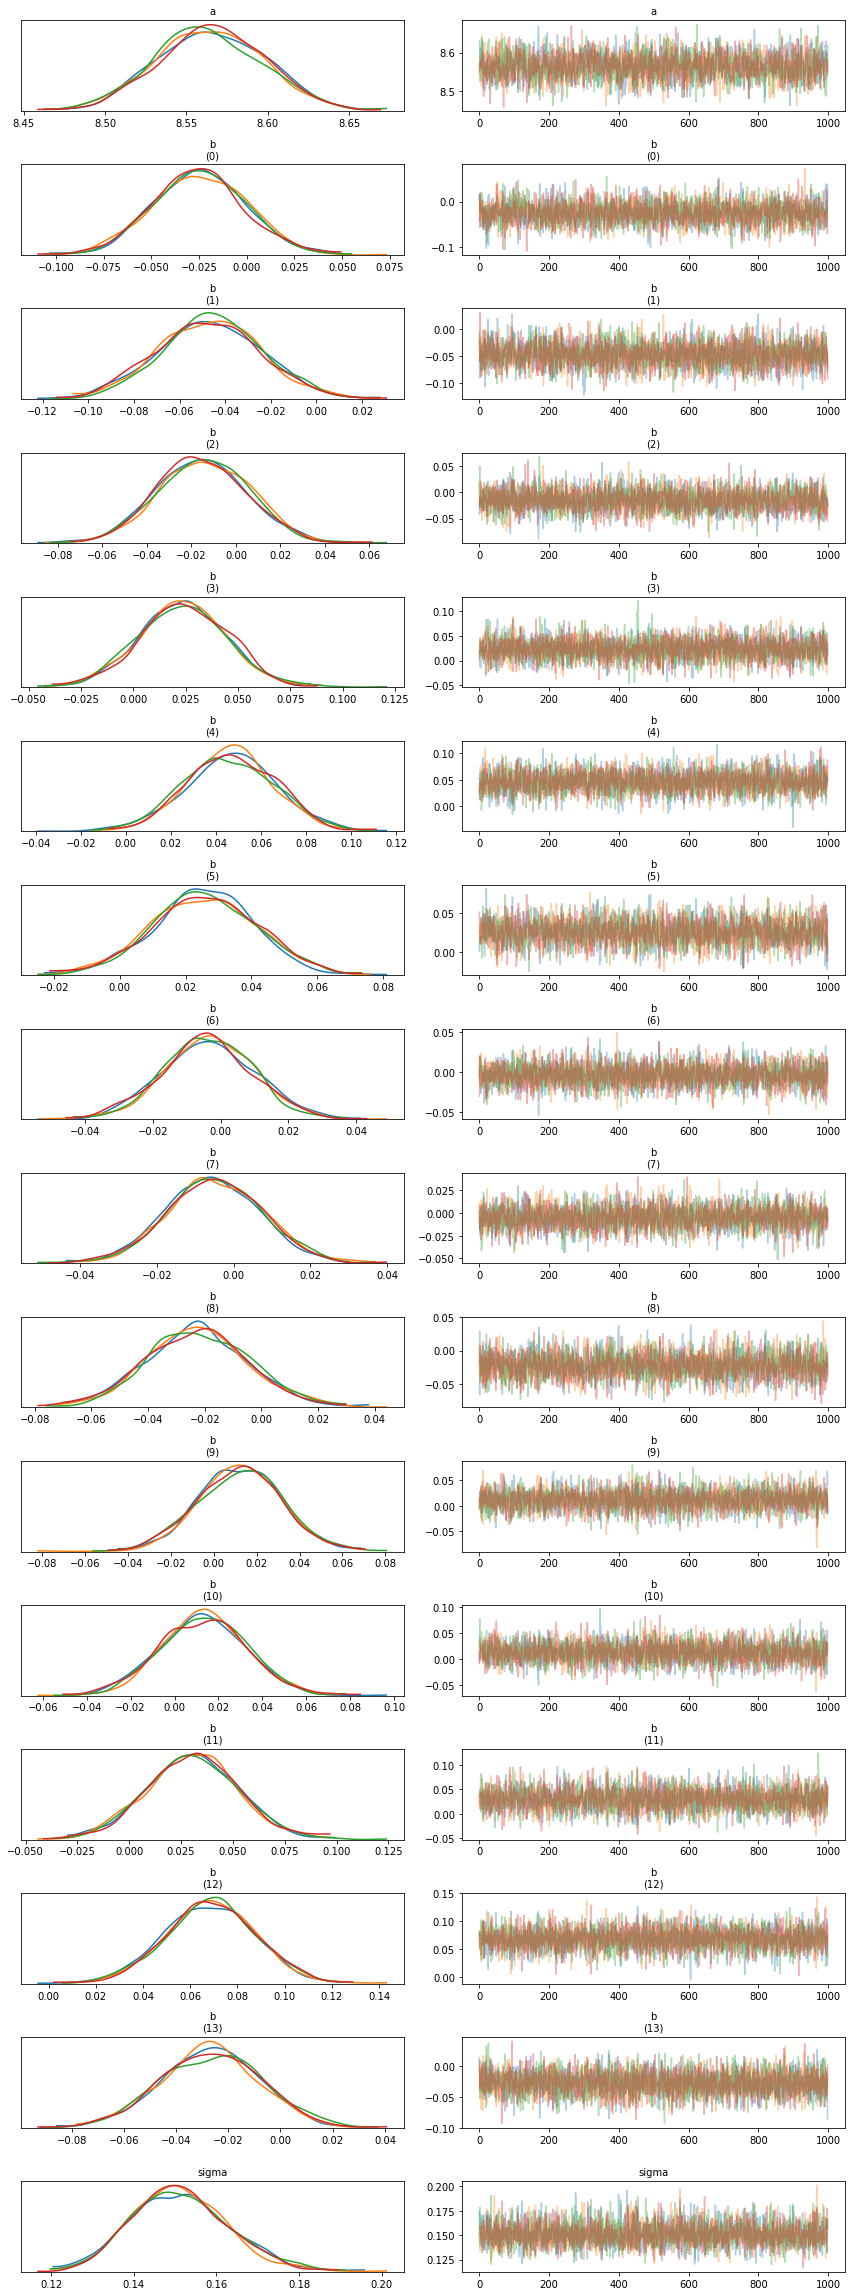

In [93]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [94]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


E-BFMI                                              Model   div energy  \
0    NaN               Model 1: 3 Predictors, Uninformative  True   True   
0    NaN          Model 2: 3 Predictors, Weakly informative  True   True   
0    NaN                      Model 3: 5 Predictors, Weakly  True   True   
0    NaN         Model 4: 5 Predictors, Interaction terms 1  True   True   
0    NaN         Model 5: 5 Predictors, Interaction terms 2  True   True   
0    NaN               Model 6: 5 Predictors, Squared terms  True   True   
0    NaN  Model 7: 5 Predictors, squared terms + interac...  True   True   

           loo       loo_se        p_loo treedepth warning  
0   113.134365  2313.256802  6710.799655      True       1  
0  -182.752072  2227.493028  6360.651857      True       1  
0  -368.520370  2228.400129  6055.112946      True       1  
0  1794.886995  2387.476891  7255.105740      True       1  
0  4859.278628  2675.355310  8092.530278      True       1  
0  3047.778717  2434.348557  7351.170899      True       1  
0  5927.174580  2854.107108  8120.721566      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [95]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


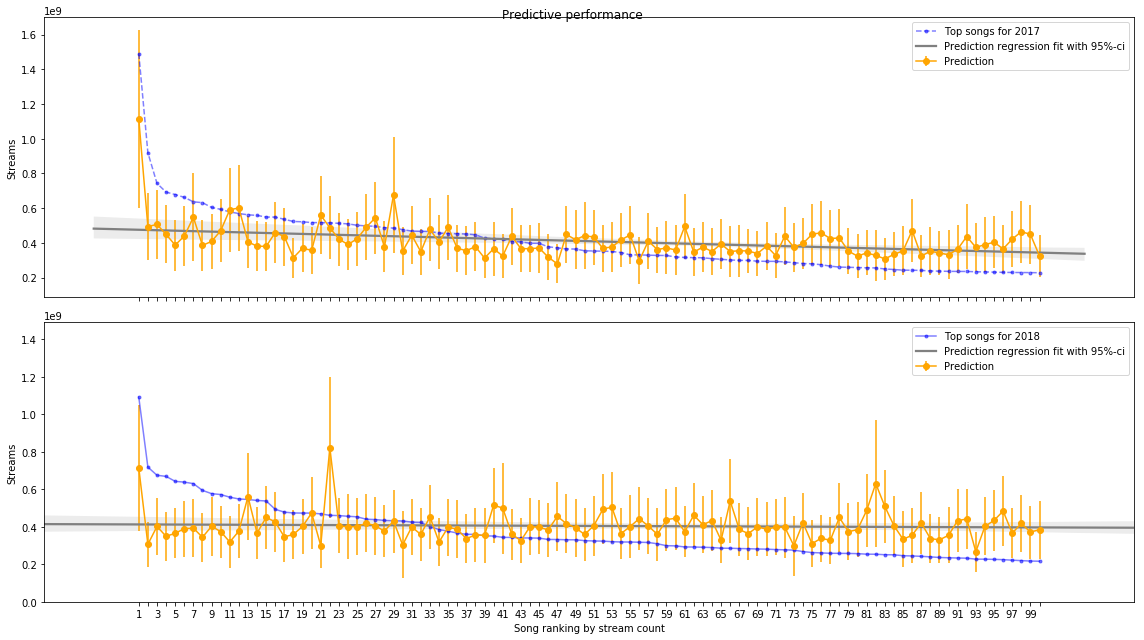

In [96]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __3.8 Extended model 5__ | Adding third order polynomials
Finally we will also basic third order polynomials. Model takes the following form:

$$ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_1^2 + \beta_7 X_2^2 + \beta_8 X_3^2 + \beta_9 X_4^2 + \beta_{10} X_5^2 + \beta_{11} X_1^3 + \beta_{12} X_2^3 + \beta_{13} X_3^3 + \beta_{14} X_4^3  + \beta_{15} X_5^3 + \beta_{16} X_2 X_4 + \beta_{17} X_3 X_5 +\beta_{18} X_1 X_5 + \beta_{19} X_2 X_5, \;\sigma)$$


### __Load model__

In [99]:
model_name = ['Model 8: 5 Predictors, cubic terms + interaction']
filename = 'lin_5_informative-third_order-inter.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points

    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[19] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[19] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X1X5;
    vector[N] X2X5;
    vector[N] X3X5;
    vector[N] X11;
    vector[N] X22;
    vector[N] X33;
    vector[N] X44;
    vector[N] X55;
    vector[N] X111;
    vector[N] X222;
    vector[N] X333;
    vector[N] X444;
    vector[N] X555;
    
    X1X5 = X1 .* X5;
    X2X5 = X2 .* X5;
    X3X5 = X

In [100]:
num_b = next(nums_b)
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [101]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e63d24688df71087ad0181e964883f54 NOW.
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp4br3d1f0/stanfit4anon_model_e63d24688df71087ad0181e964883f54_3983460430391620735.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [102]:
samples = fit.extract(permuted=True) # Extract samples
samples_list.append(samples)         # Save samples for model selection/comparison

### __Simulation results__ | Posterior

In [103]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

mean   se_mean        sd      2.5%       25%       50%       75%  \
a      8.557212  0.000775  0.039244  8.477829  8.531668  8.557815  8.583278   
b[1]  -0.021050  0.000600  0.031094 -0.080961 -0.042399 -0.020863 -0.000105   
b[2]  -0.046514  0.000483  0.029030 -0.105608 -0.064987 -0.046206 -0.026365   
b[3]   0.018745  0.000615  0.032225 -0.045155 -0.002900  0.019021  0.040730   
b[4]   0.003301  0.000670  0.034663 -0.064376 -0.019676  0.003797  0.027091   
b[5]   0.025795  0.000690  0.037124 -0.045448  0.000141  0.024907  0.050762   
b[6]   0.044607  0.000709  0.034435 -0.023258  0.021377  0.044885  0.067655   
b[7]   0.002852  0.000317  0.017921 -0.033028 -0.008993  0.002888  0.014751   
b[8]  -0.029341  0.000323  0.018336 -0.066230 -0.041771 -0.028899 -0.016735   
b[9]  -0.028490  0.000429  0.023305 -0.074801 -0.044104 -0.028912 -0.012719   
b[10]  0.017303  0.000330  0.019167 -0.019899  0.004567  0.017175  0.030329   
b[11] -0.008250  0.000353  0.014933 -0.037219 -0.018529 -0.008057  0.001583   
b[12]  0.000186  0.000137  0.007764 -0.015086 -0.005069 -0.000016  0.005345   
b[13] -0.013686  0.000157  0.008116 -0.029772 -0.019085 -0.013564 -0.008392   
b[14]  0.008828  0.000256  0.012570 -0.016067  0.000128  0.008918  0.017501   
b[15]  0.008597  0.000282  0.015011 -0.021267 -0.001288  0.008845  0.019246   
b[16]  0.025965  0.000477  0.023640 -0.020712  0.009744  0.026055  0.041345   
b[17]  0.032566  0.000378  0.021836 -0.009986  0.017749  0.032410  0.046901   
b[18]  0.065281  0.000301  0.019350  0.027975  0.052323  0.065185  0.078316   
b[19] -0.019751  0.000299  0.020033 -0.059490 -0.032782 -0.019931 -0.006758   
sigma  0.149995  0.000187  0.011857  0.129196  0.141579  0.149250  0.157357   

          97.5%        n_eff      Rhat  
a      8.632504  2561.930567  1.001242  
b[1]   0.039793  2687.875616  1.001089  
b[2]   0.009379  3607.879764  1.000438  
b[3]   0.082405  2744.084519  0.999865  
b[4]   0.071207  2680.141424  1.000031  
b[5]   0.099988  2894.477615  0.999973  
b[6]   0.111173  2358.360376  1.001277  
b[7]   0.038978  3188.376702  1.000188  
b[8]   0.006245  3214.915935  0.999753  
b[9]   0.017893  2947.583218  1.001398  
b[10]  0.055285  3368.659039  0.999679  
b[11]  0.021108  1791.010809  1.001988  
b[12]  0.015937  3234.569204  1.000688  
b[13]  0.002265  2682.407298  0.999605  
b[14]  0.033688  2412.230676  1.000152  
b[15]  0.037060  2829.347716  0.999918  
b[16]  0.071825  2455.873803  1.001684  
b[17]  0.076441  3338.225954  0.999324  
b[18]  0.103221  4121.872364  0.999564  
b[19]  0.020027  4493.814880  0.999618  
sigma  0.175968  4021.489963  0.999798

$\hat R$ and $n_{eff}$ diagnostics pass, convergence has happened with very high certainty. 

Next we check __divergence, treedepth__ and __energy__:

In [104]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [105]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [106]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 0.899084332297002) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.8760463278770231) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.9415439257580425) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.875690391904237) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


### __Plot Trace and Kernel Density Estimates__ | Convergence

Text(0.5, 0.98, '')

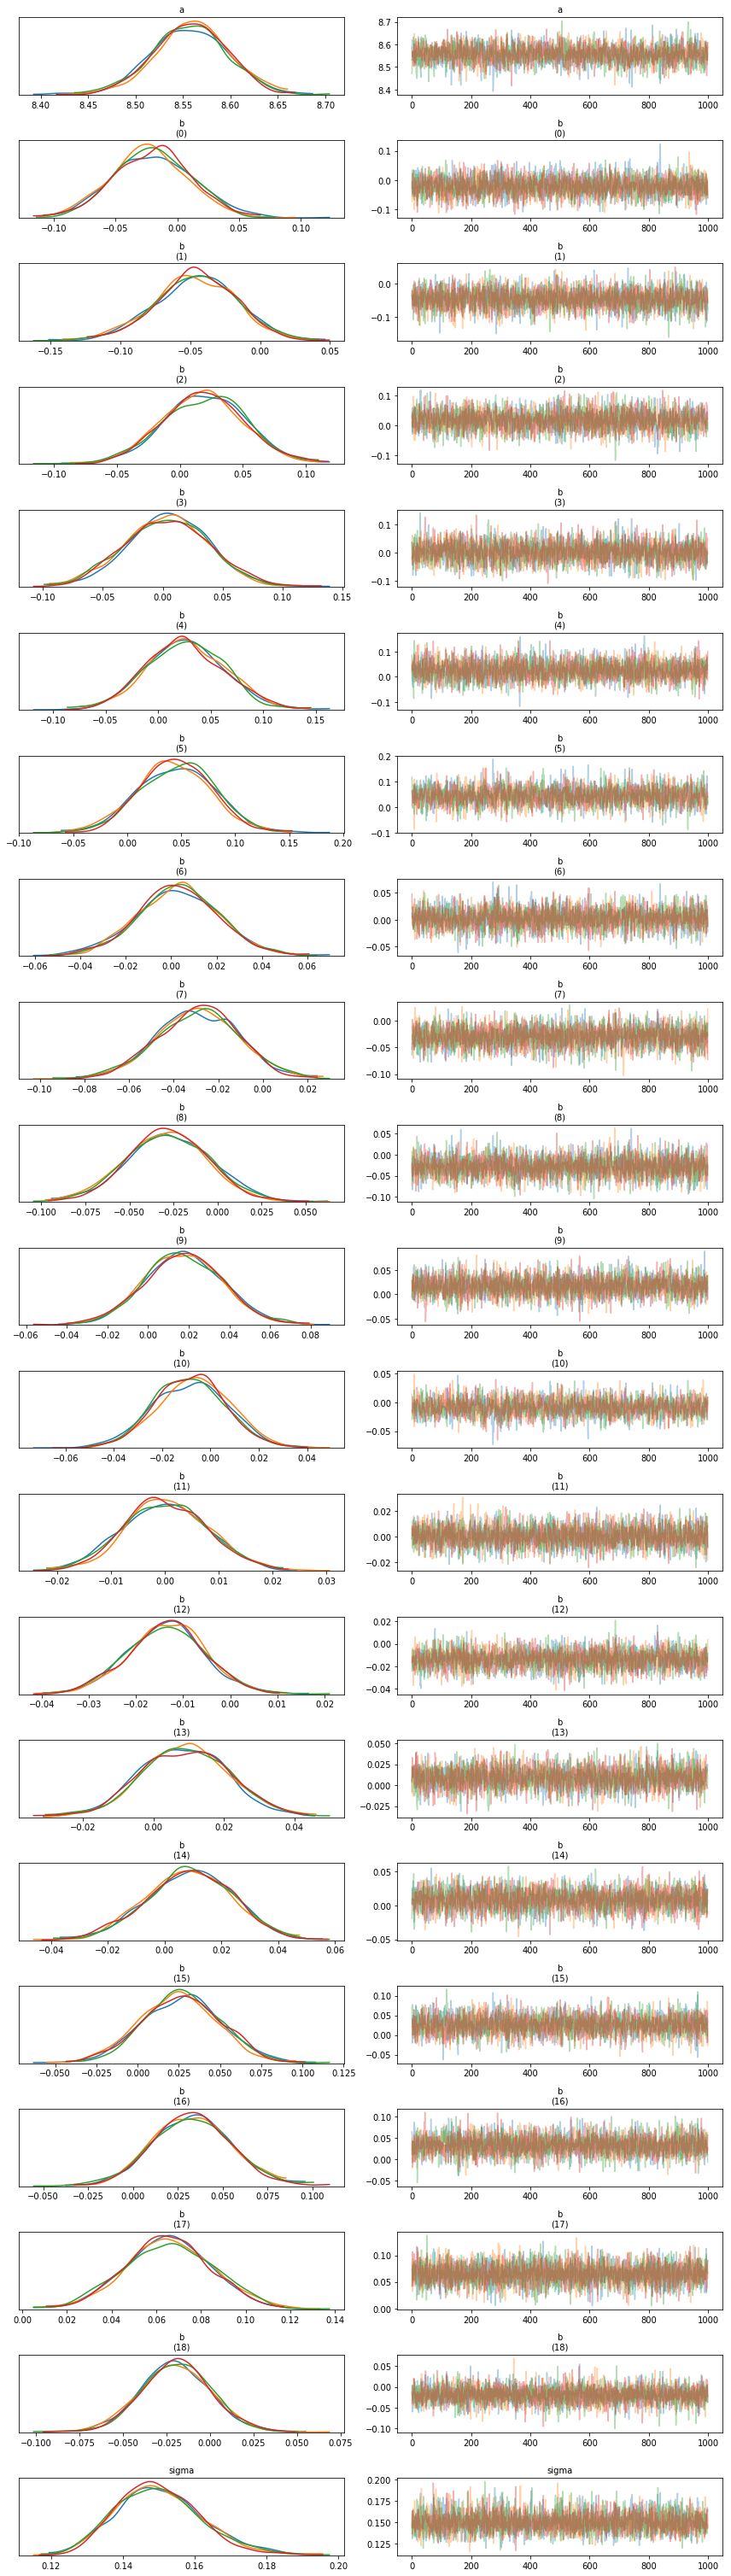

In [107]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

__Convergence results__:

### __Model check__ | Cross validation


In [111]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
loo_m = az.loo(azfit)
loo_m['Model'] = model_name
loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
loos = loos.append(loo_m, sort=True)
loo_m.set_index('Model')

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


E-BFMI                                              Model   div energy  \
0    NaN                      Model 3: 5 Predictors, Weakly  True   True   
0    NaN         Model 4: 5 Predictors, Interaction terms 1  True   True   
0    NaN         Model 5: 5 Predictors, Interaction terms 2  True   True   
0    NaN               Model 6: 5 Predictors, Squared terms  True   True   
0    NaN  Model 7: 5 Predictors, squared terms + interac...  True   True   
0    NaN   Model 8: 5 Predictors, cubic terms + interaction  True   True   
0    NaN   Model 8: 5 Predictors, cubic terms + interaction  True   True   

           loo       loo_se        p_loo treedepth warning  
0  -368.520370  2228.400129  6055.112946      True       1  
0  1794.886995  2387.476891  7255.105740      True       1  
0  4859.278628  2675.355310  8092.530278      True       1  
0  3047.778717  2434.348557  7351.170899      True       1  
0  5927.174580  2854.107108  8120.721566      True       1  
0  8414.274866  2962.374761  9225.259686      True       1  
0  8414.274866  2962.374761  9225.259686      True       1

### __Predictive accuracy__ | Predict streams for 2018

In [109]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


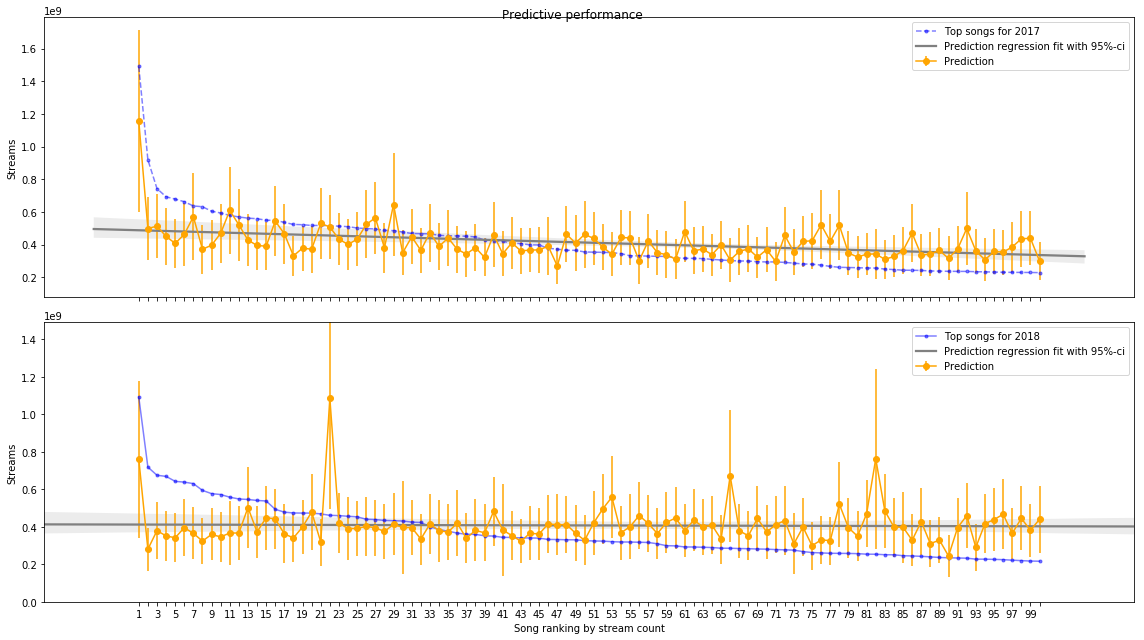

In [110]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

## __Model Comparison__
Models perform

In [199]:
loos.set_index('Model')

div energy          loo  \
Model                                                                  
Model 1: 3 Predictors, Uninformative        True   True   113.134365   
Model 2: 3 Predictors, Weakly informative   True   True  -182.752072   
Model 3: 5 Predictors, Weakly               True   True  -368.520370   
Model 4: 5 Predictors, Interaction terms 1  True   True  1794.886995   
Model 5: 5 Predictors, Interaction terms 2  True   True  4859.278628   
Model 6: 5 Predictors, Squared terms        True   True  3047.778717   

                                                 loo_se        p_loo  \
Model                                                                  
Model 1: 3 Predictors, Uninformative        2313.256802  6710.799655   
Model 2: 3 Predictors, Weakly informative   2227.493028  6360.651857   
Model 3: 5 Predictors, Weakly               2228.400129  6055.112946   
Model 4: 5 Predictors, Interaction terms 1  2387.476891  7255.105740   
Model 5: 5 Predictors, Interaction terms 2  2675.355310  8092.530278   
Model 6: 5 Predictors, Squared terms        2434.348557  7351.170899   

                                           treedepth warning  
Model                                                         
Model 1: 3 Predictors, Uninformative            True       1  
Model 2: 3 Predictors, Weakly informative       True       1  
Model 3: 5 Predictors, Weakly                   True       1  
Model 4: 5 Predictors, Interaction terms 1      True       1  
Model 5: 5 Predictors, Interaction terms 2      True       1  
Model 6: 5 Predictors, Squared terms            True       1

We can see that the more complex models are quite likely overfitting